In [1]:
import torch
from torch import utils
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torch.utils.data import WeightedRandomSampler, DataLoader

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tabulate import tabulate

from sklearn.metrics import confusion_matrix


In [2]:
#GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on", device)
torch.cuda.empty_cache()

Running on cuda


In [3]:
path = os.getcwd() + '/AugmentedData/'
classes = os.listdir(path)
classes.sort()

In [4]:
#Create the tensor transforms
transform_general = transforms.Compose(
    [transforms.ToTensor()])

#Load Dataset
print(path)
data = datasets.ImageFolder(path, transform=transform_general)

# Split into train/val/test sets:
#80% of the full dataset is used for training
train_len = int(len(data)*0.8)
trainData, remaining = random_split(data, [train_len, len(data) - train_len])
#80% of the remaining dataset
val_len = int(len(remaining)*0.8)
valData, testData = random_split(remaining, [val_len, len(remaining) - val_len])

print("Train set : ", len(trainData))
print("Val set : ", len(valData))
print("Test set : ", len(testData))

c:\Users\Divya\Desktop\Kvasir-Capsule-ML-Project\kvasir-capsule-ML-prediction/AugmentedData/
Train set :  14835
Val set :  2967
Test set :  742


In [5]:
#Calculating Class weights 

# Extract classes:
train_classes = [trainData.dataset.targets[i] for i in trainData.indices]
# Calculate support:
class_count = Counter(train_classes)
# Calculate class weights:
class_weights = torch.DoubleTensor([len(train_classes)/c for c in pd.Series(class_count).sort_index().values])
# Sampler needs the respective class weight supplied for each image in the dataset:
sample_weights = [class_weights[trainData.dataset.targets[i]] for i in trainData.indices]
print(sample_weights)
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=int(len(trainData)*2), replacement=True)

[tensor(18.6369, dtype=torch.float64), tensor(18.6136, dtype=torch.float64), tensor(18.6136, dtype=torch.float64), tensor(18.6136, dtype=torch.float64), tensor(6.3806, dtype=torch.float64), tensor(4.3969, dtype=torch.float64), tensor(11.9061, dtype=torch.float64), tensor(6.3806, dtype=torch.float64), tensor(11.9061, dtype=torch.float64), tensor(4.3969, dtype=torch.float64), tensor(6.3806, dtype=torch.float64), tensor(4.3969, dtype=torch.float64), tensor(4.3969, dtype=torch.float64), tensor(18.8981, dtype=torch.float64), tensor(18.6136, dtype=torch.float64), tensor(18.8981, dtype=torch.float64), tensor(18.7074, dtype=torch.float64), tensor(6.3806, dtype=torch.float64), tensor(18.8261, dtype=torch.float64), tensor(6.3806, dtype=torch.float64), tensor(18.7074, dtype=torch.float64), tensor(18.7074, dtype=torch.float64), tensor(6.3806, dtype=torch.float64), tensor(18.5437, dtype=torch.float64), tensor(18.8261, dtype=torch.float64), tensor(4.3969, dtype=torch.float64), tensor(18.7547, dtype=

In [6]:
# Torch dataloaders:
batch_size = 32
dataloaders = DataLoader(data, batch_size=batch_size, sampler=sampler, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The total number of images is:", len(dataloaders))

train = DataLoader(trainData, batch_size=batch_size, sampler=sampler, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a training set is:", len(train)*batch_size)

val = DataLoader(valData, batch_size=batch_size, shuffle=False, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a validation set is:", len(val)*batch_size)

test = DataLoader(testData, batch_size=batch_size, shuffle=True, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a test set is:", len(test)*batch_size)
print(dataloaders.dataset)

The total number of images is: 928
The number of images in a training set is: 29696
The number of images in a validation set is: 2976
The number of images in a test set is: 768
Dataset ImageFolder
    Number of datapoints: 18544
    Root location: c:\Users\Divya\Desktop\Kvasir-Capsule-ML-Project\kvasir-capsule-ML-prediction/AugmentedData/
    StandardTransform
Transform: Compose(
               ToTensor()
           )


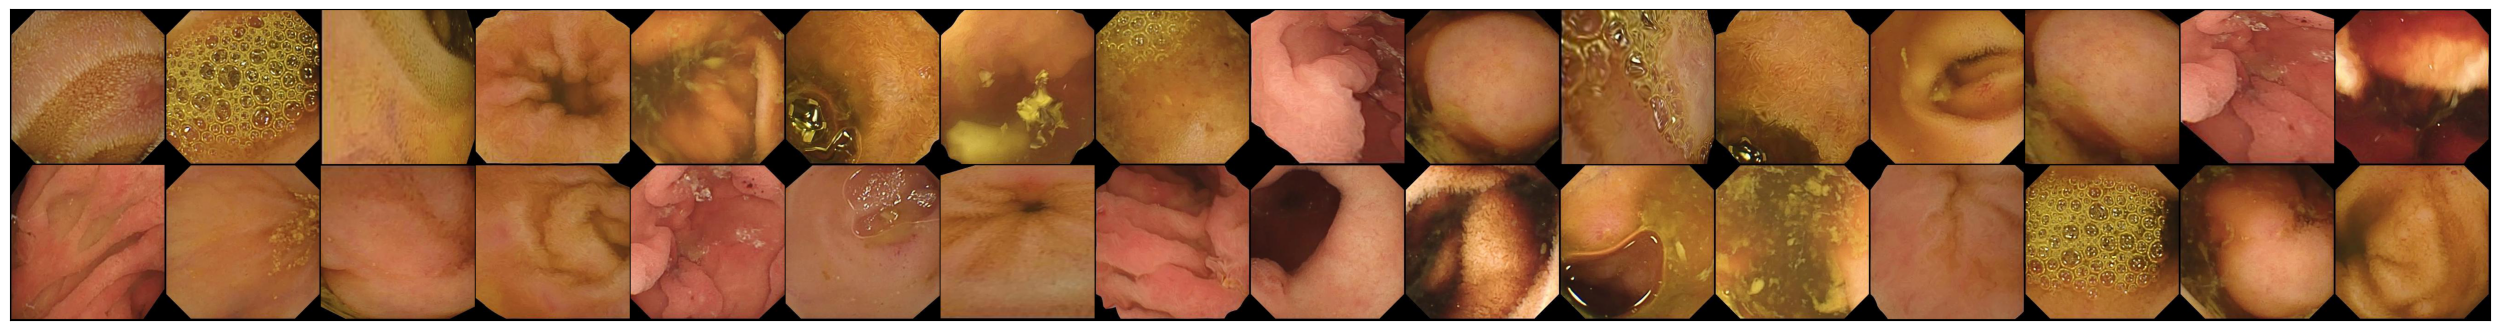

In [7]:
def show_batch(dl):
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (32,32))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break

show_batch(train)

In [8]:
#Creating a simple CNN architechture
class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()

    #Defining a sequential model layers
    self.c1 = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size=5, padding=0, stride=1),
        nn.LeakyReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.c2 = nn.Sequential(
        nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size=3, padding=0, stride=1),
        nn.LeakyReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.c3 = nn.Sequential(
        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size=3, padding=1, stride=2),
        nn.LeakyReLU(),
        nn.AvgPool2d(kernel_size=2, stride=2)
    )
    self.drop = nn.Dropout()
    self.fc = nn.Linear(in_features = 25600, out_features = 14)

  def forward(self, x):
    output = self.c1(x)
    output = self.c2(output)
    output = self.drop(output)
    output = self.c3(output)
    #or nn.Flatten()
    output = output.reshape(output.size(0), -1)
    # Each img : (336 x 336)
    # Formula : w' = ((W - F + 2P)/S) + 1
    output = self.fc(output)
    return output


In [9]:
#Define model
model = SimpleCNN().to(device)
print(model)

from torchsummary import summary
summary(model, (3, 336, 336))

SimpleCNN(
  (c1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (c2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (c3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (drop): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=25600, out_features=14, bias=True)
)
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 166, 166]        --
|    └─Conv2d: 2-1                       [-1, 16, 332, 332]        1,216
|    └─LeakyReLU: 2-2                    [-1, 16, 332, 332] 

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 166, 166]        --
|    └─Conv2d: 2-1                       [-1, 16, 332, 332]        1,216
|    └─LeakyReLU: 2-2                    [-1, 16, 332, 332]        --
|    └─MaxPool2d: 2-3                    [-1, 16, 166, 166]        --
├─Sequential: 1-2                        [-1, 32, 82, 82]          --
|    └─Conv2d: 2-4                       [-1, 32, 164, 164]        4,640
|    └─LeakyReLU: 2-5                    [-1, 32, 164, 164]        --
|    └─MaxPool2d: 2-6                    [-1, 32, 82, 82]          --
├─Dropout: 1-3                           [-1, 32, 82, 82]          --
├─Sequential: 1-4                        [-1, 64, 20, 20]          --
|    └─Conv2d: 2-7                       [-1, 64, 41, 41]          18,496
|    └─LeakyReLU: 2-8                    [-1, 64, 41, 41]          --
|    └─AvgPool2d: 2-9                    [-1, 64, 20, 20]          --
├─Lin

In [10]:
lossCriteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
#Visulaize the Results
def plot_acc_curve(train_accuracy, validation_accuracy):

  plt.plot(train_accuracy, color='green')
  #plt.plot(validation_accuracy, color='blue')
  plt.xlabel('epoch')
  plt.ylabel('Accuracy')
  plt.title('Training Accuracy')

  plt.show()

def plot_loss_curve(train_losses, validation_losses):
  plt.plot(train_losses, color='green')
  #plt.plot(validation_losses, color='blue')
  plt.xlabel('epoch')
  plt.ylabel('Loss')
  plt.title('Training Losses')

  plt.show()

In [12]:
def train_validate_test_model(e, train, test, val, model, optimizer):

  train_losses = []
  train_accuracy_list = []

  test_losses = []
  test_accuracy_list = []

  val_losses = []
  val_accuracy_list = []

  # Initialize the prediction and label lists(tensors)
  predlist=torch.zeros(0,dtype=torch.long, device='cpu')
  lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

  predlist__ =torch.zeros(0,dtype=torch.long, device='cpu')
  lbllist__ =torch.zeros(0,dtype=torch.long, device='cpu')

  for epoch in range(e):

    run_loss = 0.0
    val_loss = 0.0
    t_loss = 0.0

    #TRAINING

    model.train()
    correct = 0
    total = 0

    for img, class_ in train:

          img, class_ = img.to(device), class_.to(device)

          optimizer.zero_grad()
          preds = model(img)

          loss = lossCriteria(preds, class_)

          loss.backward()
          optimizer.step()

          run_loss += loss.item()

          _, predicted = preds.max(1)
          total += class_.size(0)
          correct += predicted.eq(class_).sum().item()


    accuracy_train = correct * 100. / total
    train_accuracy_list.append(accuracy_train)


    train_loss = run_loss / len(train.sampler)
    train_losses.append(train_loss)

    #validate
    with torch.no_grad():
      model.eval()
      correct_ = 0
      total_ = 0

      for img, class_ in val:

          img, class_ = img.to(device), class_.to(device)

          preds_ = model(img)
          loss = lossCriteria(preds_, class_)
          val_loss += loss.item()

          _, predicted = preds_.max(1)
          total_ += class_.size(0)
          correct_ += predicted.eq(class_).sum().item()

          #Append batch prediction results
          predlist = torch.cat([predlist, predicted.view(-1).cpu()])
          lbllist = torch.cat([lbllist, class_.view(-1).cpu()])


    accuracy_val = correct_ * 100. / total_
    val_accuracy_list.append(accuracy_val)


    val_loss = val_loss / len(test.sampler)
    val_losses.append(val_loss)


    print('Epoch: {} \tTraining Loss: {:.4f} \tTraining Accuracy: {:.4f} \tValidation Loss: {:.4f} \tValidation Accuracy: {:.4f}'.format(epoch, train_loss, accuracy_train, val_loss, accuracy_val))

  #test
  with torch.no_grad():
    model.eval()
    correct_ = 0
    total_ = 0

    for img, class_ in test:

        img, class_ = img.to(device), class_.to(device)

        preds_ = model(img)
        loss = lossCriteria(preds_, class_)
        t_loss += loss.item()

        _, predicted = preds_.max(1)
        total_ += class_.size(0)
        correct_ += predicted.eq(class_).sum().item()

        #Append batch prediction results
        predlist__ = torch.cat([predlist__, predicted.view(-1).cpu()])
        lbllist__ = torch.cat([lbllist__, class_.view(-1).cpu()])

    accuracy_test = correct_ * 100. / total_
    test_accuracy_list.append(accuracy_test)


    t_loss = t_loss / len(test.sampler)
    test_losses.append(t_loss)

  #Confusion matrix
  conf_mat_val = confusion_matrix(lbllist.numpy(), predlist.numpy())
  print("The Val conf mat ", conf_mat_val)

  #Confusion matrix
  conf_mat_test = confusion_matrix(lbllist.numpy(), predlist.numpy())
  print("The Test conf mat ", conf_mat_test)


  return train_losses, train_accuracy_list, test_losses, test_accuracy_list, val_losses, val_accuracy_list, conf_mat_val, conf_mat_test


In [13]:
train_losses, train_accuracy, test_losses, test_accuracy, val_losses, val_accuracy, conf_matrix_val, conf_matrix_test = train_validate_test_model(20, train, test, val, model, optimizer)

Epoch: 0 	Training Loss: 0.0241 	Training Accuracy: 75.4432 	Validation Loss: 0.0582 	Validation Accuracy: 84.9006
Epoch: 1 	Training Loss: 0.0077 	Training Accuracy: 92.0863 	Validation Loss: 0.0478 	Validation Accuracy: 87.6306
Epoch: 2 	Training Loss: 0.0049 	Training Accuracy: 95.2107 	Validation Loss: 0.0361 	Validation Accuracy: 91.6077
Epoch: 3 	Training Loss: 0.0033 	Training Accuracy: 96.5622 	Validation Loss: 0.0463 	Validation Accuracy: 89.9562
Epoch: 4 	Training Loss: 0.0027 	Training Accuracy: 97.2026 	Validation Loss: 0.0430 	Validation Accuracy: 91.4392
Epoch: 5 	Training Loss: 0.0021 	Training Accuracy: 97.8429 	Validation Loss: 0.0432 	Validation Accuracy: 92.4166
Epoch: 6 	Training Loss: 0.0019 	Training Accuracy: 98.0452 	Validation Loss: 0.0414 	Validation Accuracy: 93.2929
Epoch: 7 	Training Loss: 0.0018 	Training Accuracy: 98.2609 	Validation Loss: 0.0530 	Validation Accuracy: 89.3158
Epoch: 8 	Training Loss: 0.0013 	Training Accuracy: 98.5811 	Validation Loss: 0.

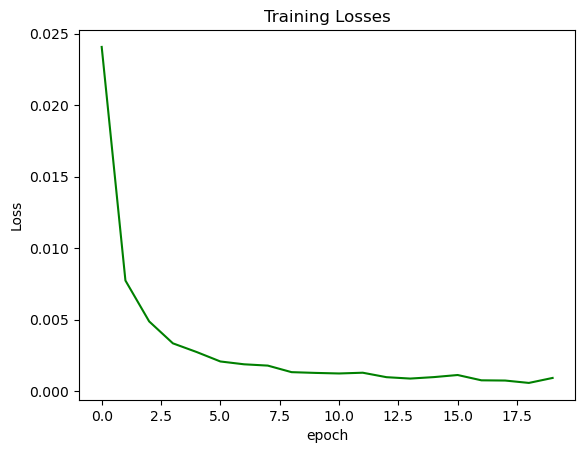

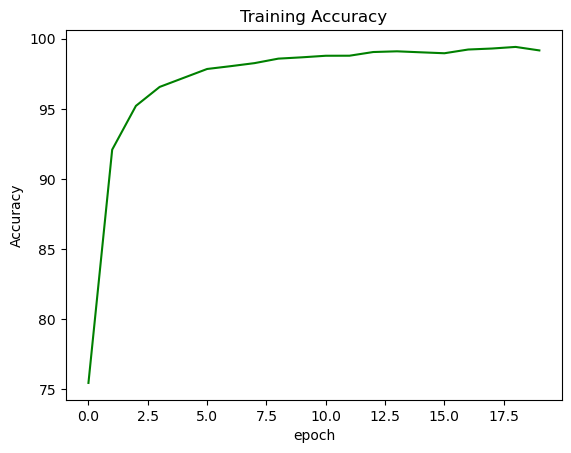

In [14]:
#Visualize Epoch training
plot_loss_curve(train_losses, val_losses)
plot_acc_curve(train_accuracy, val_accuracy)

In [15]:
classes = os.listdir(path)
classes.sort()

In [16]:
#Evaluation
#Function to calculate the F1 score
def get_f1_score(conf_matrix, i):
    TP, FP, TN, FN = 0, 0, 0, 0

    for j in range(len(conf_matrix)):
        if (i == j):
            TP += conf_matrix[i, j]
            tmp = np.delete(conf_matrix, i, 0)
            tmp = np.delete(tmp, j, 1)

            TN += np.sum(tmp)
        else:
            if (conf_matrix[i, j] != 0):

                FN += conf_matrix[i, j]
            if (conf_matrix[j, i] != 0):

                FP += conf_matrix[j, i]

    recall = TP / (FN + TP)
    precision = TP / (TP + FP)
    f1_score = 2 * 1/(1/recall + 1/precision)

    return f1_score

#function to retrieve class accuracies for each class
def per_class_accuracies(conf_mat):
  class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
  print("Per class accuracy : ", class_accuracy)
  return class_accuracy

Confusion matrix of testing Phase :


<Axes: >

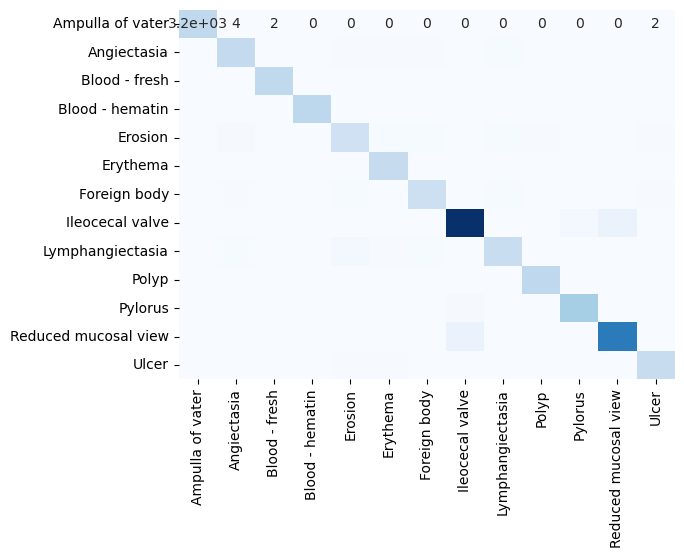

In [17]:
#Validation Phase Results
print("Confusion matrix of testing Phase :")
sns.heatmap(pd.DataFrame(conf_matrix_test, index=classes, columns=classes), 
            annot=True, cmap='Blues', cbar=False)


In [18]:
class_accuracies = per_class_accuracies(conf_matrix_val)

f1Scores = []
for i in range(len(classes)-1):
    f1Scores.append(get_f1_score(conf_matrix_test, i))
print("The f1 scores for Induvidual classes are : ", f1Scores)

Per class accuracy :  [99.75       88.85294118 94.79041916 99.3373494  75.625      94.14012739
 83.60927152 91.01837672 80.68965517 99.65838509 92.73333333 91.41163793
 91.00628931]
The f1 scores for Induvidual classes are :  [0.9871656100201021, 0.8776873910517141, 0.9533273110508883, 0.9877208745133274, 0.7811491284699806, 0.9112207151664613, 0.8508845829823084, 0.9143142835166526, 0.8389602629220196, 0.9849600982197667, 0.9187582562747688, 0.9078067312322757]


In [19]:
headers = ['Class', 'Accuracy', 'F1 Score']
print(tabulate(zip(classes, class_accuracies, f1Scores), headers=headers, floatfmt=".4f"))

Class                   Accuracy    F1 Score
--------------------  ----------  ----------
Ampulla of vater         99.7500      0.9872
Angiectasia              88.8529      0.8777
Blood - fresh            94.7904      0.9533
Blood - hematin          99.3373      0.9877
Erosion                  75.6250      0.7811
Erythema                 94.1401      0.9112
Foreign body             83.6093      0.8509
Ileocecal valve          91.0184      0.9143
Lymphangiectasia         80.6897      0.8390
Polyp                    99.6584      0.9850
Pylorus                  92.7333      0.9188
Reduced mucosal view     91.4116      0.9078
